# Tarea 3, IMT2220, semestre 2025-1

Este notebook muestra la funcionalidad del algoritmo FFT proporcionado por SciPy.

Analizamos las frecuencias de una función trigonométrica que representa una base de datos con temperatura horaria.

In [279]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq
from scipy.signal import find_peaks

Asumimos que la base de datos viene con una temperatura cada hora. Por tanto, la medida de unidad del tiempo es horas. Para testear el análisis de Fourier, generamos una serie de tiempo con un punto de muestra cada hora (sampling rate = 1) y una duración de diez días (240 horas).

In [280]:
sampling_rate = 1 # número de mediciones por hora
time_length = 24 * 10 # número de horas para generar datos

In [281]:
n_samples = sampling_rate * time_length

La frecuencia de la temperatura esperada es un día. Es decir, hay oscilaciones diarias en la temperatura. Dado que la base de datos es en horas, tenemos que definir la frecuencia como el inverso de 24 horas.

In [282]:
frequency = 1 / 24 # la frecuencia es un día, 24 horas

Generamos la temperatura horaria, donde elegimos una temperatura promedio de 20 grados con cambios de 10 grados y un error de medición Gausiano.

In [283]:
time_samples = np.linspace(0, time_length, n_samples, endpoint=False)
temperature = 20 + 10 * np.cos(2*np.pi * frequency * time_samples) + np.random.normal(0, 1, n_samples)

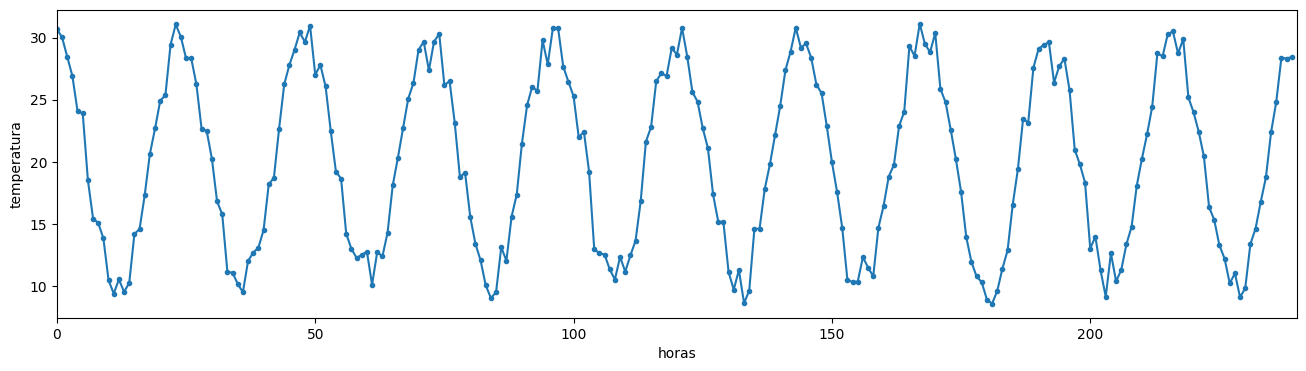

In [284]:
fig = plt.figure(figsize=(16,4))

plt.plot(time_samples, temperature, marker='.')

plt.xlim([0, time_length])

plt.xlabel('horas')
plt.ylabel('temperatura')

plt.show()

Calculamos la transformada de Fourier de la temperatura con el algoritmo Real Fast Fourier Transform (RFFT). Además, calculamos las frecuencias que corresponden a la salida de la función de SciPy.

In [285]:
temperature_fft = rfft(temperature)
freqs_fft = rfftfreq(n_samples, 1 / sampling_rate)

In [286]:
temperature_fft_scaled = np.abs(temperature_fft) / (n_samples/2) # ponderar la amplitud de cada frecuencia
freqs_fft_day = freqs_fft * 24 # cambiar la frecuencia de horas a días

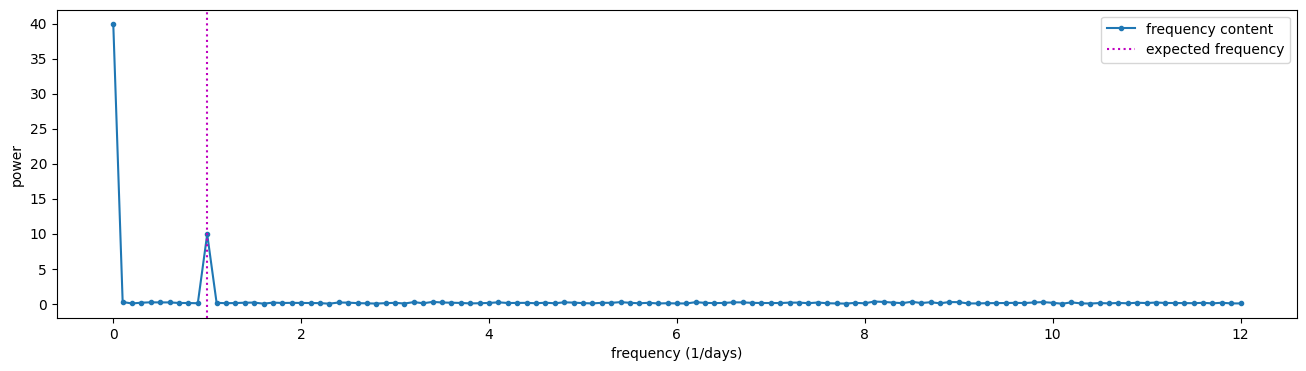

In [287]:
fig = plt.figure(figsize=(16,4))

plt.plot(freqs_fft_day, temperature_fft_scaled, marker='.', label='frequency content')
plt.axvline(frequency*24, color='m', linestyle=':', label='expected frequency')

plt.xlabel('frequency (1/days)')
plt.ylabel('power')
plt.legend()

plt.show()

Buscamos los peaks con una altura de al menos un grado Celsius.

In [288]:
peaks, _ = find_peaks(temperature_fft_scaled, height=1)

# agregamos a mano el primer índice, lo cual no es considerado un máximo local
# pero sí tiene información relevante

for p in [0] + list(peaks):
    print("Peak en ubicación", p, ":")
    print("  Frecuencia:", freqs_fft_day[p], "por día")
    print("  Amplitud:", temperature_fft_scaled[p], "grados Celsius")

Peak en ubicación 0 :
  Frecuencia: 0.0 por día
  Amplitud: 39.973918025217884 grados Celsius
Peak en ubicación 10 :
  Frecuencia: 1.0 por día
  Amplitud: 9.932275967418411 grados Celsius


Efectivamente se puede ver un valor de diez en la frecuencia de un día, como se espera para una oscilación con amplitud 10 y periodo de 1 día. El peak para la frecuencia cero corresponde a la temperatura promedia en estos días. Su amplitud es dos veces la temperatura promedio porque es en el borde del dominio de las frecuencias.

Inicio de la tarea:

1. Baje todos los datos de la temperatura horaria en la estación de Quinta Normal, desde el junio 2015 hasta el mayo 2025. Pueda ser desde
MeteoChile o el archivo disponible en Canvas.

En la siguiente celda, usamos los datos entregados en Canvas, y los cargamos usando el fichero .csv, que contiene la data, pero lo cargamos con uso de la librería pandas, para poder manipular los datos.

Como no se pide el medio de cargar los datos, se asume que es en formato .csv, ya que cualquier formato de los entregados debería servir. Además, se asume el nombre del archivo (data.csv).

In [289]:
import pandas as pd

# Intentamos cargar la base de datos en formato CSV.

try:
    df = pd.read_csv('data.csv')
    print("\nInformación del DataFrame: \n")
    df.info()
except Exception as e:
    print(f"Error :{e} \n")


Información del DataFrame: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87440 entries, 0 to 87439
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Fecha            87440 non-null  object 
 1   Hora (UTC)       87440 non-null  object 
 2   Temperatura (C)  87432 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


2. La base de datos tiene varios datos NaN.

a) ¿Cuántos valores NaN hay?

Usando el DataFrame de la librería pandas definido anteriormente, obtenemos la serie de valores (pandas.Series) booleanos que nos indica los valores que son Null, y luego los contamos con el método .sum(). La pregunta pide decir la cantidad de valores NaN en la base de datos, pero dado que el método .isnull() cuenta los valores que son NaN en caso de ser numéricos, estamos respondiendo adecuadamente, respondimos para las tres columnas del dataset la cantidad de valores nulos.

In [290]:
# Número de entradas con NaN en la fecha:
number_of_nan_fecha = df['Fecha'].isnull().sum()

# Número de entradas con NaN en la hora:
number_of_nan_hora = df['Hora (UTC)'].isnull().sum()

# Número de entradas con NaN en la temperatura:
number_of_nan_temperatura = df['Temperatura (C)'].isnull().sum()

print(f"Número de horas sin un valor de temperatura: {number_of_nan_fecha}")

print(f"Número de horas sin un valor de temperatura: {number_of_nan_hora}")

print(f"Número de horas sin un valor de temperatura: {number_of_nan_temperatura}")

Número de horas sin un valor de temperatura: 0
Número de horas sin un valor de temperatura: 0
Número de horas sin un valor de temperatura: 8



b) Limpie la base de datos para evitar los valores NaN. Explique
cómo lo hicieron y por qué tu algoritmo no afecta al resultado
final de RFFT.

Primero que nada, combinamos las columnas fecha y hora en una nueva columna de tipo datatime con la información correspondiente, para posteriores análisis, y borramos las columnas fecha y hora, ya que tenemos la información en la nueva columna.

Con respecto a la limpieza, limpiamos los NaNs con los métodos de la librería pandas; .interpolate(), y .fillna(). Elegimos el interpolado con una escala lineal, y utilizamos fillna dos veces, una vez con forward fill (method = ffill) , y otra con backward fill (method = bfill).

EDIT: Se ha utilizado, en vez de los métodos .fillna(method=bfill) o .fillna(method=ffill), los métodos recomendados en la librería actualmente: .ffill() y .bfill()

El interpolado estimará los valores restantes y los rellenará, pero se utilizó también el .fillna para tener mayor robustez, ya que hay algunos datos que el método .interpolate aplicado al DataFrame podría no considerar.

Este método no afecta al algoritmo RFFT porque hemos asegurado que al eliminar los valores nulos o not a number, se rellenaran esos valores con estimaciones según los datos cercanos a éste valor faltante, por lo que tenemos una progresión uniforme de los valores faltantes, suponiendo que la estimación es adecuada. Es importante hacer notar que la RFFT no sólo se ve afectada si los valores faltantes están mal estimados, también se ve afectada si hay datos faltantes, el algoritmo requiere datos significativos y uniformemente espaciados, en este caso con respecto al tiempo.

In [291]:
# Como dijimos en la celda anterior, mezclamos la fecha y la hora en UTC en una nueva col de tipo Datetime:
df['Datetime'] = pd.to_datetime(df['Fecha'] + ' ' + df['Hora (UTC)'], format='%d-%m-%Y %H:%M') # Formato día/mes/año

# Creamos el nuevo DF, agregándole la columna Datetime, y luego elimiando las columnas de fecha y hora:
df_datetime = df.set_index('Datetime').copy() # .copy para copiar por valor, y no por referencia en memoria.
df_datetime = df_datetime.drop(columns=['Fecha', 'Hora (UTC)'])

# Para el nuevo DF, reemplazamos la columna temperatura con la nueva, interpolando linealmente y  aplicando
# el rellenado de valores nulos con method forward y backward, como se explicó en la celda anterior.
df_datetime['Temperatura (C)'] = \
    df_datetime['Temperatura (C)'].interpolate(method='linear').ffill().bfill()

print("\nDataFrame después de limpiar 'Temperatura (C)' para la Pregunta 8.b (sin extender a 10 años):")
print(df_datetime.head())

# Comprobamos que no existan valores nulos:
print(f"Valores nulos en temperatura luego de la limpieza: {df_datetime['Temperatura (C)'].isnull().sum()}")


DataFrame después de limpiar 'Temperatura (C)' para la Pregunta 8.b (sin extender a 10 años):
                     Temperatura (C)
Datetime                            
2015-06-01 00:00:00              9.8
2015-06-01 01:00:00              8.8
2015-06-01 02:00:00              8.5
2015-06-01 03:00:00              7.7
2015-06-01 04:00:00              7.3
Valores nulos en temperatura luego de la limpieza: 0


3. Visualice la temperatura en la base de datos en tres figuras:

a) la serie de tiempo completo

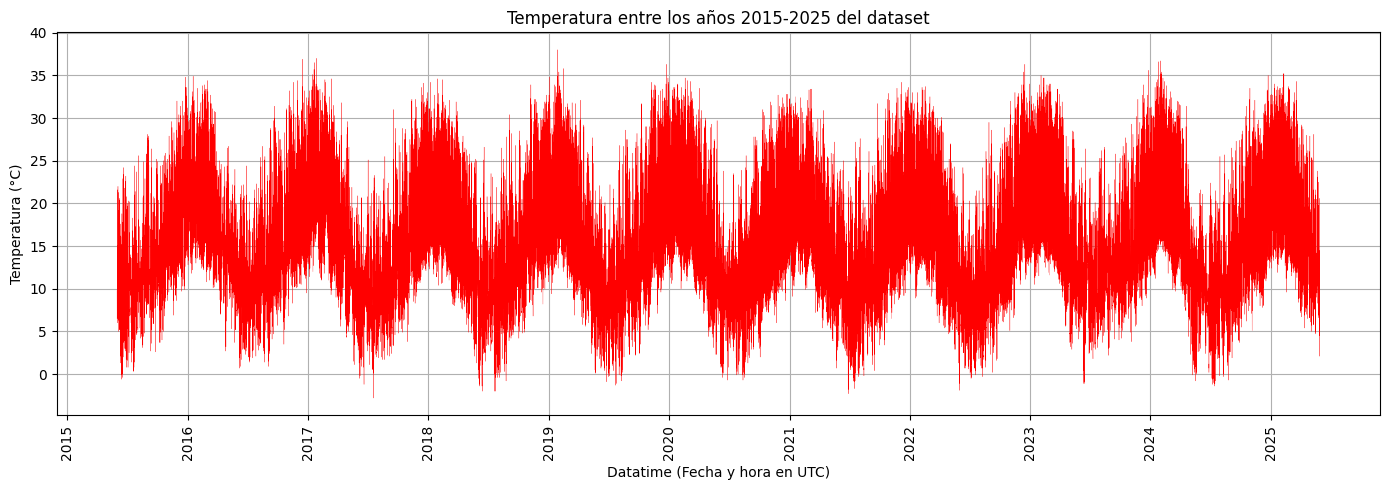

In [292]:
# Visualización de todos los valores del dataset:
plt.figure(figsize=(14, 5))
# En esta gráfica, ya que tiene 10 años en valores, ponemos linewidth más delgada que las posteriores:
plt.plot(df_datetime.index, df_datetime['Temperatura (C)'], color='red', linewidth=0.2)
plt.title('Temperatura entre los años 2015-2025 del dataset')
plt.xlabel('Datatime (Fecha y hora en UTC)')
plt.xticks(rotation=90) # Rotamos en 90 grados la xlabel, para ver mejor
plt.ylabel('Temperatura (°C)')
plt.grid(True) # Grid, para mejoor referencia.
plt.tight_layout() # Ajusta márgenes.

b) el primer mes

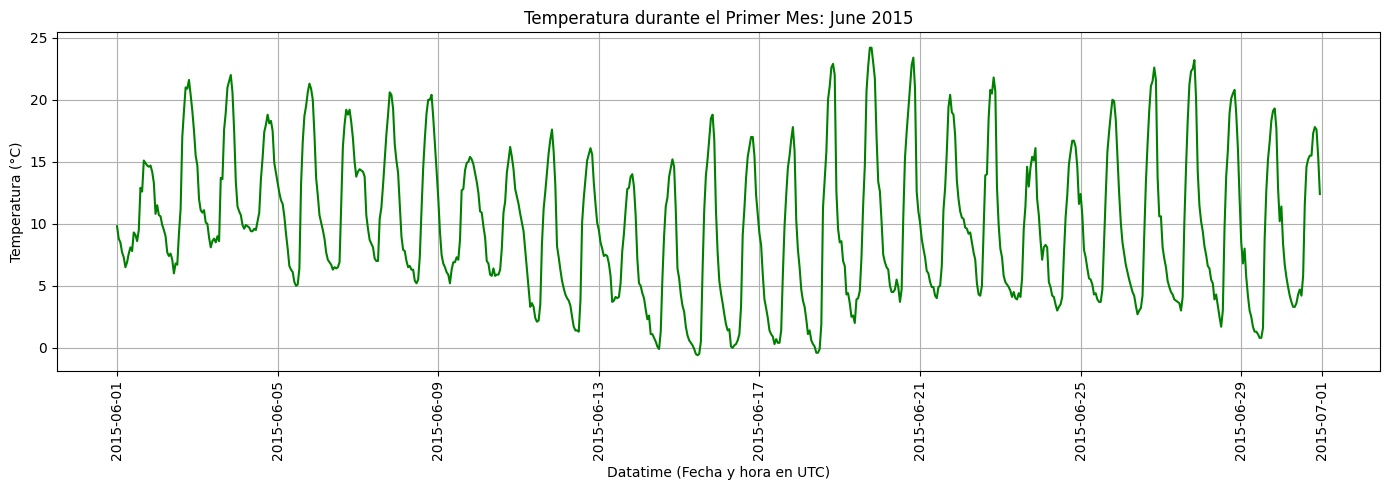

In [293]:
# Podríamos seleccionar específicamente por fecha, en un mes específico, pero lo correcto es seleccionar
# el inicio y fin del primer mes de esta forma con pandas, para que funcione dinámicamente si los datos cambian:
first_month_inicio = df_datetime.index.min().to_period('M').start_time # Inicio del primer mes
first_month_fin = df_datetime.index.min().to_period('M').end_time # Fin del primer mes
df_first_month = df_datetime.loc[first_month_inicio:first_month_fin] # último mes

plt.figure(figsize=(14, 5))
plt.plot(df_first_month.index, df_first_month['Temperatura (C)'], color='green')
plt.title(f'Temperatura durante el Primer Mes: {first_month_inicio.strftime("%B %Y")}')
plt.xlabel('Datatime (Fecha y hora en UTC)')
plt.xticks(rotation=90) # Rotamos en 90 grados la xlabel, para ver mejor
plt.ylabel('Temperatura (°C)')
plt.grid(True) # Grilla
plt.tight_layout()

c) el último mes.

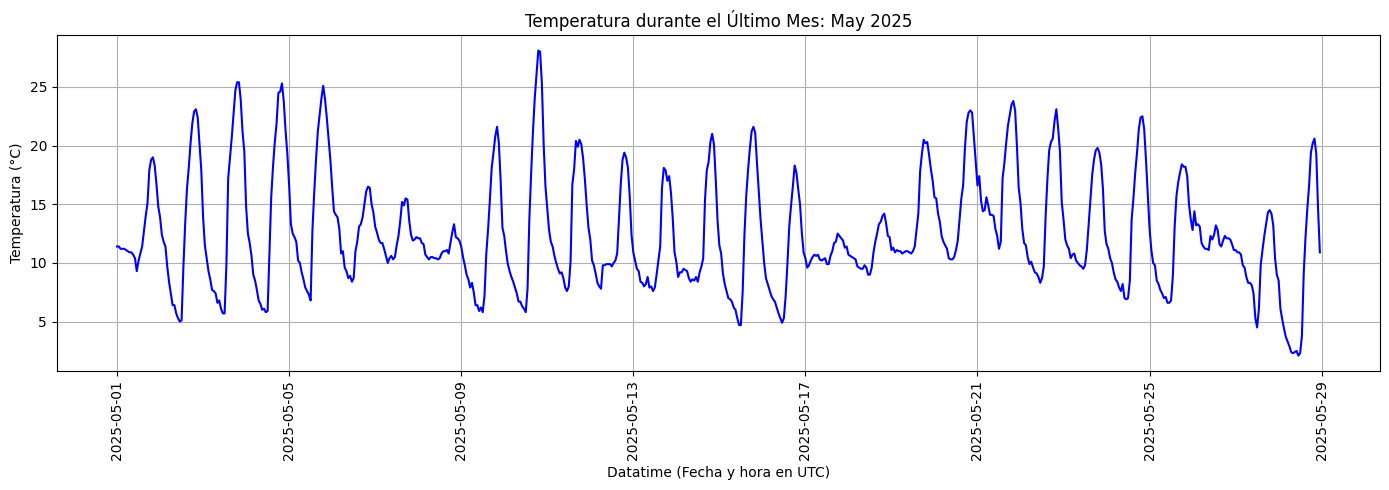

In [294]:
# Igual que en la visualización anterior, usamos pandas para dinámicamente obtener el inicio y fin el último mes.
last_month_inicio = df_datetime.index.max().to_period('M').start_time # Inicio del último mes
last_month_fin = df_datetime.index.max().to_period('M').end_time # Fin del último mes
df_last_month = df_datetime.loc[last_month_inicio:last_month_fin] # último mes

plt.figure(figsize=(14, 5))
plt.plot(df_last_month.index, df_last_month['Temperatura (C)'], color='blue')
plt.title(f'Temperatura durante el Último Mes: {last_month_inicio.strftime("%B %Y")}')
plt.xlabel('Datatime (Fecha y hora en UTC)')
plt.xticks(rotation=90) # Rotamos en 90 grados la xlabel, para ver mejor
plt.ylabel('Temperatura (°C)')
plt.grid(True) # Grilla
plt.tight_layout()

4. Aplique el algoritmo RFFT a toda la serie de tiempo de la temperatura.
Ver Canvas para un ejemplo del algoritmo RFFT.

a) ¿Cómo eligieron el sampling rate?

Primero que nada, siguiendo el ejemplo del algoritmo RFFT de Canvas, elegimos el sampling rate como 1, ya que es el número de mediciones por hora, y el dataset contiene 24 valores cada día, una temperatura para cada hora en formato UTC.

Para ello, debemos tomar primero la longitud del DF en su columnas temperatura, para obtener la cantidad de datos y, con  ello, obtener el número de muestras (en la variable n_samples)

In [295]:
# Valores de la temperatura del DF, almacenados como un array de numpy:
temperature_series = df_datetime['Temperatura (C)'].values
print(f"temperature_series type: {type(temperature_series)}")

sampling_rate = 1 # Una medición de temperatura cada hora
n_samples = len(temperature_series) # Número de muestras obtenidas dinámicamente.

# Calculamos la RFFT a partir de los valores de la temperatura
temperature_fft = rfft(temperature_series)

# Calcular las frecuencias correspondientes
# El segundo argumento es 'd' (spacing de la muestra). Como sampling_rate es 1 muestra/hora, d=1 hora.
freqs_fft = rfftfreq(n_samples, 1 / sampling_rate) # Frecuencias en ciclos/hora

# Ponderamos la amplitud de cada frecuencia con la fórmula del ejemplo, hay que dividir
# la frecuencia actual por (n_samples/2) para obtener la amplitud real actual:
temperature_fft_scaled = np.abs(temperature_fft) / (n_samples / 2)

# Como en el ejemplo, calculamos la frecuencia en ciclos/día, a partir de la inicial,
# que está en ciclos/hora:
freqs_fft_day = freqs_fft * 24

temperature_series type: <class 'numpy.ndarray'>


b) Visualice los resultados de RFFT: dibuje la amplitud para cada frecuencia

<ipython-input-296-2945631202>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


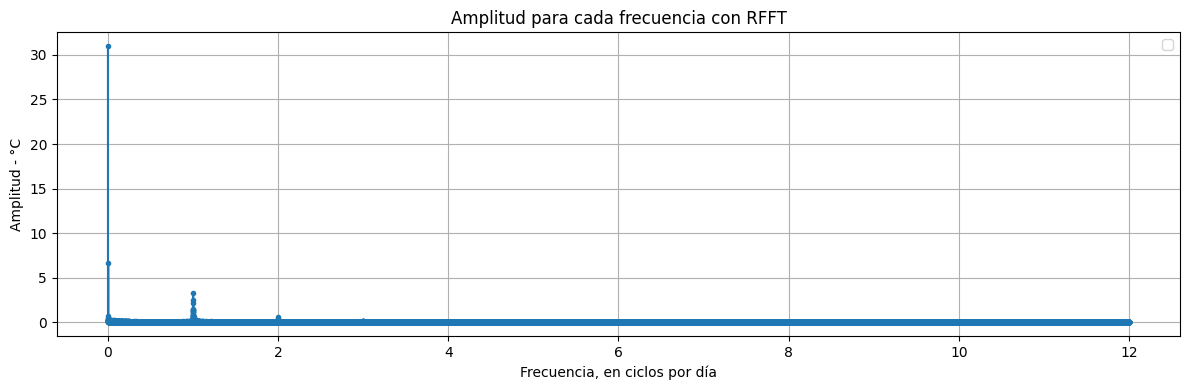

In [296]:
fig = plt.figure(figsize=(12, 4))
plt.plot(freqs_fft_day, temperature_fft_scaled, marker='.')

#plt.xlim([-0.01, max]) Aquí, podemos hacer "zoom" para ver más de cerca los valores de la freq,
# dado que se ven demasiado juntas las frecuencias, si graficamos completamente todo de una vez.
plt.xlabel('Frecuencia, en ciclos por día')
plt.ylabel('Amplitud - °C')
plt.legend()
plt.grid(True)
plt.title('Amplitud para cada frecuencia con RFFT')
plt.tight_layout()
plt.show()

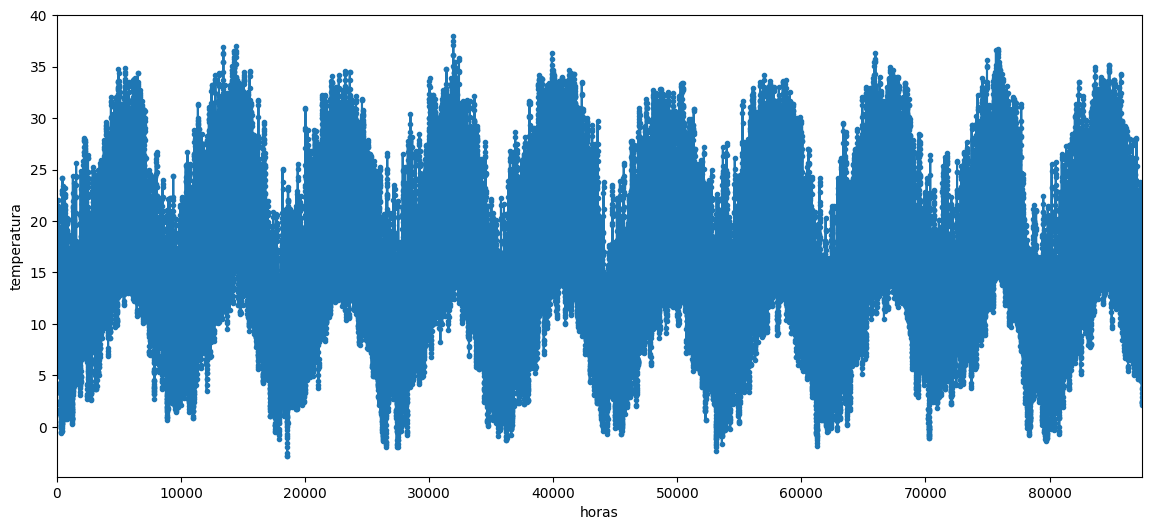

In [297]:
# La siguiente gráfica es sólo para probar que todo esté bien.

fig = plt.figure(figsize=(14,6))

time_length = n_samples

time_samples = np.linspace(0, time_length, n_samples, endpoint=False)

plt.plot(time_samples, temperature_series, marker='.')

plt.xlim([0, time_length])

plt.xlabel('horas')
plt.ylabel('temperatura')

plt.show()

5. Una frecuencia tiene unidad física de 1/tiempo con el tiempo en alguna unidad como segundo, hora, día, año, etc.

a) Para cada frecuencia que entrega el RFFT, calcule la frecuencia en la unidad de 1/día

En el ítem 4.a ya hemos calculado la frecuencia en la unidad 1/día, siguiendo el ejemplo de Canvas, y lo hemos almacenado en la variable freqs_fft_day

In [298]:
# Convertimos las frecuencias a la unidad de 1/día, se multiplica por 24 porque hay 24 horas en un día,
# y las muestras tienen una hora de sepración entre cada una:
freqs_fft_day = freqs_fft * 24 # Ya calculada en 4.a
temperature_fft_scaled = np.abs(temperature_fft) / (n_samples / 2)

print(f"Frecuencias calculadas en la unidad de 1/día (primeras 5): {freqs_fft_day[:5]} ciclos/día")
print(f"Amplitudes de RFFT correspondientes a las frecuencias calculadas (primeras 5): {temperature_fft_scaled[:5]} °C")
print(f"La longitud de las frecuencias calculadas es: {len(freqs_fft_day)}")

Frecuencias calculadas en la unidad de 1/día (primeras 5): [0.         0.00027447 0.00054895 0.00082342 0.0010979 ] ciclos/día
Amplitudes de RFFT correspondientes a las frecuencias calculadas (primeras 5): [30.97255833  0.13732164  0.09840077  0.38691433  0.11488911] °C
La longitud de las frecuencias calculadas es: 43721


b) Visualice los resultados de RFFT, con la amplitud de RFFT en el eje vertical y la frecuencia en 1/días en el eje horizontal.

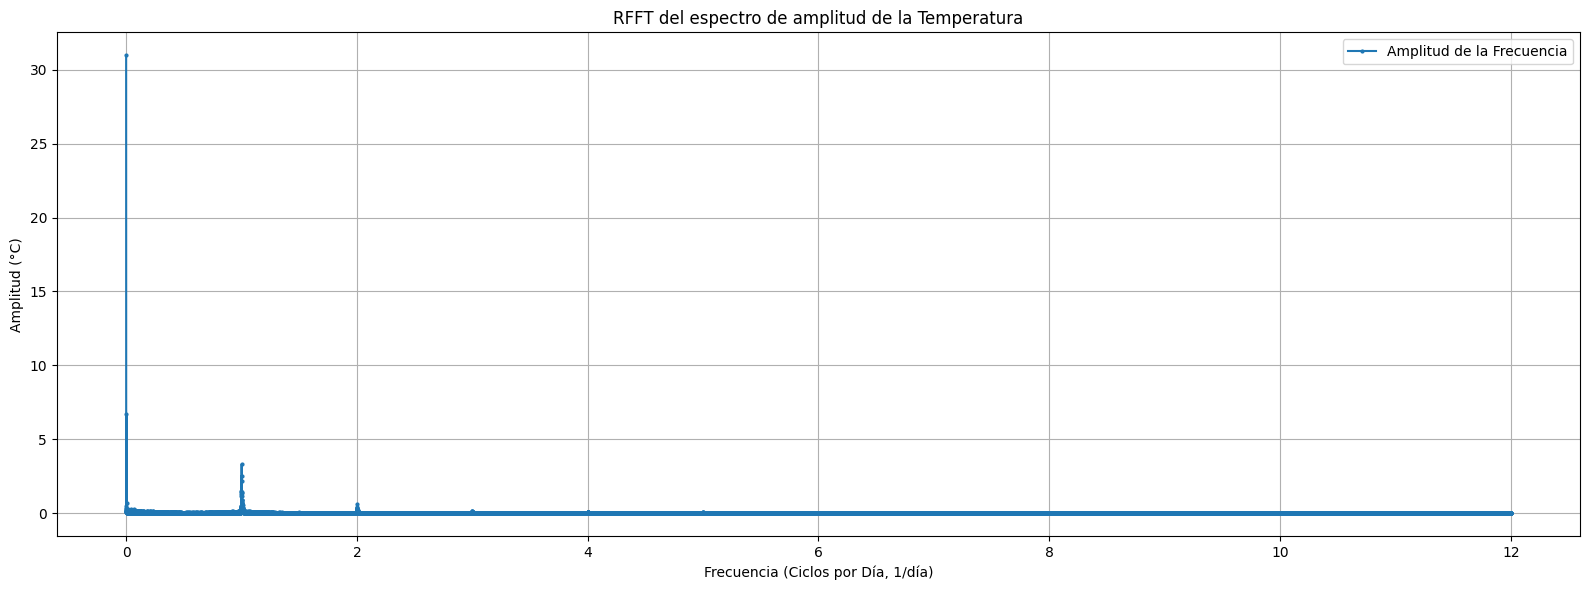

In [299]:
# Graficamos con cada frecuencia y su amplitud con freqs_fft_day, usando las variables
# anteriores de frecuencia por dia y temperatura fft escalada:

fig = plt.figure(figsize=(16, 6))
plt.plot(freqs_fft_day, temperature_fft_scaled, marker='.', linestyle='-', markersize=4, label='Amplitud de la Frecuencia')

plt.xlabel('Frecuencia (Ciclos por Día, 1/día)')
plt.ylabel('Amplitud (°C)')
plt.legend()
plt.grid(True)
plt.title('RFFT del espectro de amplitud de la Temperatura')
plt.tight_layout()
plt.show()

c) Explique por qué la frecuencia más alta es 12.

Tenemos 24 muestras para cada día, pero el teorema de muestro de Nyquist-Shannon dice que para producir una señal fielmente, necesitamos el doble de muestras de la frecuencia más alta.

Como sólo tenemos 24 muestras diarias, no podemos ver ciclos de 1 hora, por el comportamiento de las ondas. Por ejemplo, si tenemos 3 muestras, con una hora de diferencia cada una, sólo podemos ver un ciclo de 1.5 horas como maxímo, ya que para un ciclo completo, necesitamos capturar la subida y bajada de la onda, y así poder reconstruir fielmente la información.

La tasa de Nyquist nos dice la tasa de muestreo mínima que necesitamos y, si ya tenemos una cierta cantidad de muestras, la frecuencia de Nyquist nos indica la frecuencia más alta que podemos ver, el patrón o cliclo más alto que podemos apreciar. Con nuestras 24 muestras diarias, ya que necesitamos el doble de muestras de la señal más alta, 24/2 = 12, que es la frecuencia más alta que podemos obtener con nuestras muestras, por eso la frecuencia más alta es de 12 ciclos/día.

Scipy, n_samples y los datos para calcualr la RFFT, automáticamente considera esto y por eso, al graficar con matplotlib, obtenemos una gráfica con frecuencia máxima de 12 en el eje X.

Fuentes de relevancia:

https://es.wikipedia.org/wiki/Teorema_de_muestreo_de_Nyquist-Shannon


https://es.wikipedia.org/wiki/Teorema_de_muestreo_de_Nyquist-Shannon

d) Explique la significancia climatológica del peak en 1.

Aunque podemos ver valores relativamente altos en la amplitud para las frecuencias 2 y 3 también, la frecuencia en 1 tiene un peak. Entonces, como la frecuencia está en unidades de 1/día, sabemos que la frecuencia en 1 significa que hay un patrón que se repite una vez al día, una vez cada 24 horas. El patrón mencionado tiene una amplitud cercana a 4, lo que indica que hay una variación de esa amplitud cerca del valor promedio. Entonces, podemos concluir así, que dado que el peak está en 1 y tiene amplitud cercana a 4 (se puede ver el valor exacto, pero no se solicita), entonces hay una variación diaria de la temperatura promedio, de alrededor de 2 veces esa amplitud como máximo, que es cercana a 8 grados Celsius.

La tierra gira diariamente en un ciclo de 24 horas sobre su propio eje, y esto, considerando los resultados obtenidos en la amplitud, tiene una gran significancia climatológica, porque nos dice qué tan grande es la diferencia de temperatura en el transcurso del día, un peak alto indica una alta variación térmica entre el día y la noche (en caso de Santiago de Chile, por ejemplo), esto es, significa que si la temperatura promedia en Santiago, según los datos entregados por la base de datos, es de 18 grados, entonces el peak en 1 nos dice que en promedio hay una variación cada día de esa amplitud, por lo que la temperatura oscilaría entre los 14 y los 22 grados, en promedio.

Que la temperatura oscile entre Temp_Promedio + - Amplitud diariamente, nos dice mucho del clima, porque nos indica qué tanto varía en un día la temperatura en promedio, para así poder estimar temperaturas más bajas y altas, y poder realizar diferentes estimaciones según esto en conocimiento. Ejemplo: qué tipos de organismos podrían albergar vida en estas condiciones de variación térmica.

6. Puede ser más informativo visualizar los datos con el periodo en el eje horizontal.


a) Para cada frecuencia que entrega el RFFT, calcule el periodo
en la unidad de día.

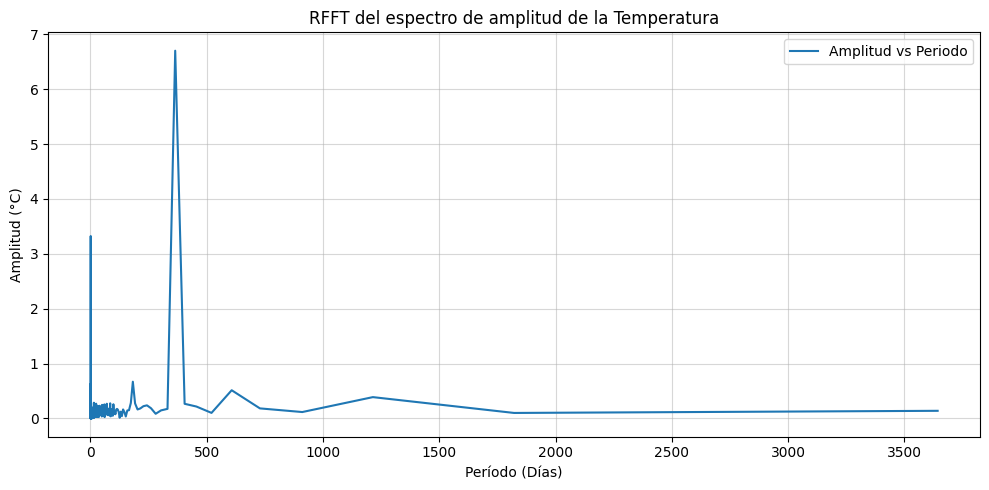

In [300]:
# Para mayor claridad, volvemos a definir las variables necesarias:
temperature_series = df_datetime['Temperatura (C)'].values
n_samples = len(temperature_series)

# Hacemos uso del RFFT para la serie de temperaturas del dataset, nuevamente:
temperature_fft = rfft(temperature_series)
# Como antes, escalamos la amplitud siguiendo el ejemplo de Canvas:
temperature_fft_scaled = np.abs(temperature_fft) / (n_samples / 2)

# Luego, convertimos las frecuencias a 1/día (ciclos por día), ya lo habíamos hecho en al menos dos celdas:
freqs_fft_day = freqs_fft * 24

# Para calcular el periodo en la unidad de día, sabemos que el periodo es uno sobre frecuencia, esto es T = 1/F,
# siendo T=periodo y F=frecuencia, pero debemos evitar el caso en el que la frecuencia es 0, porque no se puede dividir por 0:

# La frecuencia 0 corresponde a un período infinito (la componente DC).
period_days = np.zeros_like(freqs_fft_day) # Inicializamos un array para períodos
non_zero_freq_indices = freqs_fft_day != 0
period_days[non_zero_freq_indices] = 1 / freqs_fft_day[non_zero_freq_indices]

# Hay un problema, para la frecuencia con valor 0, el período es infinito al dividirse por cero, así que se puede asignar un valor np.inf:
# period_days[freqs_fft_day == 0] = np.inf

# Para las preguntas 6.b y 6.c, necesitamos graficar los resultados obtenidos:

plt.figure(figsize=(10, 5))
# Filtrar frecuencias muy bajas que darían períodos extremadamente grandes para una mejor visualización.
# Por ejemplo, solo mostrar períodos hasta ~500 días.
# O filtrar frecuencias > 0 para evitar el periodo infinito de la DC.

# Aquí filtramos frecuencias muy bajas que darían periodos muy altos para poder ver mejor, mostrando sólo hasta los días menores a 1000,
# pero con frecuencias mayores a 0, para evitar el periodo infinito comentado anteriormente:
valid_indices = (freqs_fft_day > 0) & (period_days < 10000) # Excluimos F=0, y periodos grandes, si se pone freqs_fft_day>0 hay errores graves en la visu.

plt.plot(period_days[valid_indices], temperature_fft_scaled[valid_indices], linestyle='-', label='Amplitud vs Periodo')
plt.title('RFFT del espectro de amplitud de la Temperatura')
plt.xlabel('Período (Días)')
plt.ylabel('Amplitud (°C)')
plt.grid(True, linestyle='-', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

b) Expliquen qué significa el último punto, del periodo más largo

Como el periodo está medido en días, y el más largo está cercano a la cantidad de días que corresponde a los 10 años, que es el total de nuestra muestra. Esto representa la oscilación de frecuencia más baja que la RFFT detecta, con la base de datos de 10 años, que ocurre una sola vez.

Como vemos, la amplitud en ese periodo es casi 0, pero si hubiera existido un peak, habría tenido un significado climatológico importante, quizás algún ciclo solar que sucede cada 10 años.

c) Se puede ver un peak alto entre 300 y 400. Explique su significancia climatológica

Análogamente a la pregunta 5c, el peak alto entre 300 y 400 indica un átron que se repite en la amplitud en un periodo de aproximadamente 365 días, que es un año Solar, donde podemos ver una amplitud de casi 7, lo que, al igual que antes, indica que hay una variación térmica de 7 grados Celsius alrededor del promedio, pero esta vez, como estamos graficando el periodo en días en el eje X, el peak significa que cada 1 año existe esa variación térmica, porque la transformada rápida de Fourier captura eso, los patrones repitentes en cada ciclo.

Este fenómeno ocurre por la traslación de la tierra alrededor del Sol, siguiendo las órbitas elípticas estudiadas por Nicolás Copérnico, cosa que deberíamos considerar si quisiéramos analizar más a fondo estos datos, ya que, como se menciona en el enunciado de la tarea, la tierra no orbita al Sol siguiendo circunferencias, sino que lo hace siguiendo elipses, lo que provoca que en algunos momentos la tierra esté más cerca o más lejos del Sol (Perihelio y Afelio), lo que da lugar a las estaciones del año, los equinoccios y Solsticios.

Finalmente, la importancia climatológica de este patrón es de mucha importancia, ya que marca influencia en actividades humanas como la agricultura, o simplemente la influencia del Sol en la tierra con su radiación, según momentos del periodo.

7. Encuentre los peaks en los resultados de RFFT con una amplitud de al
menos un grado Celsius e imprimen la amplitud, frecuencia y periodo
para cada peak. Ver Canvas para un ejemplo de calcular los peaks. Discute el resultado.

In [301]:
# Otra vez, volvemosa  calcular las variables que ya calculamos, para mayor claridad, pero se
# omitirán algunos comentarios porque ya se han explicado repetidamente en celdas anteriores:
temperature_series = df_datetime['Temperatura (C)'].values
n_samples = len(temperature_series)
temperature_fft = rfft(temperature_series)
temperature_fft_scaled = np.abs(temperature_fft) / (n_samples / 2) # Siguiendo lo de Canvas, escalamos la temperatura.

sampling_rate = 1 # 1 muestra por hora

# freqs_fft_day ya está definido arriba.

# Calcular períodos en días, manejando la frecuencia 0
period_days = np.zeros_like(freqs_fft_day)
non_zero_freq_indices = freqs_fft_day != 0
period_days[non_zero_freq_indices] = 1 / freqs_fft_day[non_zero_freq_indices]
period_days[freqs_fft_day == 0] = np.inf # Frecuencia 0 tiene período infinito

# Usando find_pseaks() de la librería scipy.signal, buscamos los peaks con height=1, ya que se
# pide encontrar peaks con amplitud de al menos un grado celsius:
peaks, _ = find_peaks(temperature_fft_scaled, height=1)

print("Peaks identificados en el espectro de amplitud solicitada en el enunciado >= 1°C: ")

# Asumimos que existen peaks, y agregamos a mano el primer índice, lo cual no es considerado un máximo
# local, pero sí tiene información relevante. Imprimimos los valores solicitados para cada peak:
for p in [0] + list(peaks):
    print("\n Peak en ubicación del array",p, ":")
    print("  Frecuencia:", freqs_fft_day[p], "por día")
    print("  Amplitud:", temperature_fft_scaled[p], "grados Celsius")
    print("  Período:", period_days[p], "días")

Peaks identificados en el espectro de amplitud solicitada en el enunciado >= 1°C: 

 Peak en ubicación del array 0 :
  Frecuencia: 0.0 por día
  Amplitud: 30.97255832570905 grados Celsius
  Período: inf días

 Peak en ubicación del array 10 :
  Frecuencia: 0.0027447392497712718 por día
  Amplitud: 6.703936243833141 grados Celsius
  Período: 364.3333333333333 días

 Peak en ubicación del array 3640 :
  Frecuencia: 0.9990850869167429 por día
  Amplitud: 1.5099168369272369 grados Celsius
  Período: 1.000915750915751 días

 Peak en ubicación del array 3643 :
  Frecuencia: 0.9999085086916744 por día
  Amplitud: 2.5293196615820466 grados Celsius
  Período: 1.000091499679751 días

 Peak en ubicación del array 3647 :
  Frecuencia: 1.001006404391583 por día
  Amplitud: 3.323957765273754 grados Celsius
  Período: 0.9989946074399048 días

 Peak en ubicación del array 3651 :
  Frecuencia: 1.0021043000914913 por día
  Amplitud: 1.3411664676312562 grados Celsius
  Período: 0.9979001186889437 días

 

Discutiento el resultado, podemos ver que tenemos diferentes peaks;

El primero, con periodo infinito y amplitud de 31 grados Celsius, redondeando, es la componente inicial DC, que está escalada en el código.

En cuanto a las demás, tenemos peaks con periodo de 1 año, que es un solo peak, y 5 peaks con duración de 1 día. El peak de 1 año representa, como se dijo en celdas anteriores, el ciclo anual, significa que la temperatura ha tenido una variación predominante de 6.7 grados Celsius aprox, con ciclo de un año.

En cuanto a los peaks diarios, tenemos más de uno porque la variación de temperatura que ocurre regularmente en un conjunto de días puede diferir de otro conjunto de días, hay días donde la variación promedio es mayor y otras donde es menor, nuestro algoritmo nos permite ver los peaks donde hay más ocurrencia de ciertas amplitudes, pero dado que hay una gran cantidad de muestras para miles de días, obtenemos diferentes patrones que se repiten (en este caso, sólo estamos tomando los peaks con una amplitud mayor a 1 grado Celsius). Para resumir, podemos decir que este grupo de peaks nos muestra los patrones que se repiten aproximadamente una vez al día, con la restricción dada.

8. Aunque eliminamos los NaNs de la base de datos, no revisamos si existen datos faltantes.

a) ¿Cuántos días no tiene ninguna información?

In [302]:
# Para que quede más claro, volvemos a hacer una copia del df inicial, mezclando fecha y hora en
# una nueva columna de tipo Datetime:
df_datetime = df.copy()

print("Primer valor del dataset df: \n ",df.head(1))

df_datetime['Datetime'] = pd.to_datetime(df_datetime['Fecha'] + ' ' + df_datetime['Hora (UTC)'], format='%d-%m-%Y %H:%M')
df_datetime = df_datetime.set_index('Datetime')

print("\n Primer valor del nuevo dataset df_datetime: \n ", df_datetime.head(1))

# Creamos contenedores de datos cada día, con el método .resample(), lo que rellenará los datos faltantes:
daily_counts = df_datetime.resample('D').size()

# Creamos una lista de booleanos donde los datos tienen valor cero:
daily_with_null_counts = (daily_counts == 0)
# Cada resultado booleano en la lista anterior nos indica si ese día hay 0 muestras, así que
# sumamos todos los días con cero valores, para obtener la cantidad total:
missing_days_count = daily_with_null_counts.sum()

print(f"Hay: {missing_days_count} días con registros, pero sin ninguna información")

Primer valor del dataset df: 
          Fecha Hora (UTC)  Temperatura (C)   Datetime
0  01-06-2015      00:00              9.8 2015-06-01

 Primer valor del nuevo dataset df_datetime: 
                   Fecha Hora (UTC)  Temperatura (C)
Datetime                                          
2015-06-01  01-06-2015      00:00              9.8
Hay: 0 días con registros, pero sin ninguna información


Como vemos, hay 0 días sin ninguna información, por lo que no hay datos faltantes. Es importante considerar que aquí se han buscado los **días con ninguna información**, no los días que tienen datos faltantes en alguna columna en particular del dataset, o días que tienen alguna información, porque no se pregunta esto. Aquí, entonces, no se cuentan días donde hay registros en ciertas horas faltantes.

Ahora, si la pregunta va encaminada a encontrar la cantidad de días que no están contemplados en el dataset, la respuesta sería otra:

In [303]:
# Volvemos a usar un rango dinámico de horas según las fechas límite del dataset:
rango_dinamico_horas = pd.date_range(
    start=df_datetime.index.min(),
    end=df_datetime.index.max(),
    freq='h'
)

# Re indexamos, para rellenar los valores faltantes donde no hay registros (con NaN):
df_completo = df_datetime.reindex(rango_dinamico_horas)

# Obtenemos el total de horass faltantes, los valores sumando los valores que tienen NaN
total_horas_faltantes = df_completo['Temperatura (C)'].isna().sum()

# B) Número de días con datos incompletos dentro del rango de los datos
# También, podemos hacer un agrupamiendo diario con .resample("D"), y luego contar los días que
# tienen menos de 24 muestras, la suma de ese total de días son los días en los que faltan datos:
num_dias_incompletos = (df_completo['Temperatura (C)'].resample('D').count() < 24).sum()

print(f"Horas faltantes sin datos: {total_horas_faltantes}")
print(f"Días en los que faltan datos: {num_dias_incompletos}")

Horas faltantes sin datos: 168
Días en los que faltan datos: 94


Por favor, considerar el output de la última celda como la respuesta más completa acorde a este ítem, porque contempla las horas faltantes sin datos y los días en los que faltan datos, el output de la primera celda de este ítem puede ser engañoso, como se explicó antes.

b) ¿Cuántas horas no tiene un valor de temperatura?

En las primeras celdas ya hemos limpiado los NaN, así que aquí usamos la variable df_datetime nueva, en la que se ha hecho df.copy() del dataset original, así que sólo debemos usar pandas para contar las rows que tienen valores null (en este caso, en las que no tienen valores válidos para la temperatura).

In [304]:
horas_sin_temperatura = df_datetime['Temperatura (C)'].isna().sum()

print(f"Hay {horas_sin_temperatura} horas que no tienen un registro válido para la temperatura (NaN)")

Hay 8 horas que no tienen un registro válido para la temperatura (NaN)


Vemos que, como antes, obtenemos 8 horas donde no hay un valor para la temperatura. Hay que considerar que esto no cuenta valores para los que las horas no existen, o sea, no cuenta registros faltantes, pero como sabemos que no faltan registros por la celda anterior, concluimos lo indicado.

En la celda anterior, hemos contado un total de 168 horas faltantes, que es el resultado indicado, así que depende de cómo se encamine la pregunta:

Si se pregunta por horas registradas, pero sin un valor en la columna de temperatura, la respuesta es 8.

En cambio, si se pregunta por horas que no están registradas, la respuesta asciende a 168. Creo que esto responde fielmente a la pregunta.

c) Crea una nueva base de datos con un registro para cada hora en todo el periodo de 10 años. Explique qué hicieron para llenar los datos faltantes.

Aquí, tomamos lo que hemos hecho en la celda 2b, donde está explicado lo que se hizo para rellenar los datos faltantes, se utilizó el método de interpolación con una escala lineal (aunque se pueden elegir otras), y se rellenaron posibles datos faltantes con backward y forward fill.

In [319]:
# Primero que nada, creamos un date_range con el valor mínimo y máximo para el datetime del dataset:
rango_dinamico_horas = pd.date_range(
    start=df_datetime.index.min(),
    end=df_datetime.index.max(),
    freq='h'
)

# Creamos un nuevo DF, pero le agregamos ese índice, así se crearán filas para las horas faltantes, pero
# tendrán valores NaN en la temperatura, que es el valor que falta en algunos registros:
df_datetime_completo = pd.DataFrame(index=rango_dinamico_horas)
df_datetime_completo = df_datetime_completo.join(df_datetime)

# Igual que en la celda 2b, hacemos un rellenado de los datos faltantes, con una interpolación linear para promediar:
df_datetime_completo['Temperatura (C)'] = df_datetime_completo['Temperatura (C)'].interpolate(method='linear')
df_datetime_completo['Temperatura (C)'] = df_datetime_completo['Temperatura (C)'].bfill()
df_datetime_completo['Temperatura (C)'] = df_datetime_completo['Temperatura (C)'].ffill()

print(f"Total de horas con NaN después de reindexar: {df_datetime_completo['Temperatura (C)'].isna().sum()}")

Total de horas con NaN después de reindexar: 0


La explicación de este método está explicado en la celda 2b, sólo se utilizaron los siguientes tres métodos de la librería pandas: interpolate, bfill y ffill.

9. En base a los resultados entregado por el RFFT, responde las preguntas siguientes. Ojo que deben recuperar los valores de los resultados del
RFFT, sin hacer un análisis adicional de la base de datos.

a) ¿Cuál es la temperatura promedia en Santiago en los últimos diez años?

In [321]:
temp_promedio = temperature_fft_scaled[0].real/2  # Dado que el resultado es complejo. usamos .real para obtener valor real
# También, debemos dividir el resultado entre dos, porque la amplitud está escalada para ese valor:
print(f"La temperatura promedio en Santiago en los últimos años del dataset: {temp_promedio:.2f}°C")

La temperatura promedio en Santiago en los últimos años del dataset: 15.49°C


b) ¿Cuál es, en promedio, la diferencia de temperatura (en ◦C) entre el día más frío en invierno y el día más caluroso en verano?

Primero, consideramos como Verano a diciembre, enero y febrero, y para invierno consideramos los meses junio, julio y agosto, luego hacemos índices para esos meses en el dataset, y agrupamos por día tanto para verano e invierno, para poder sacar la media de cada día, y así finalmente obtener el máximo y mínimo que se pide en la pregunta.

In [322]:
frecuencia_anual = 1 / 365.25
# Buscamos el índice de frecuencia más cercana a la anual, en el espectro generado por la Transformada de Fourier:
indice_frecuencia_anual = np.abs(freqs_fft_day - frecuencia_anual).argmin()

# Calculamos la amplitud
amplitud_estacional = np.abs(temperature_fft_scaled[indice_frecuencia_anual])

# Para ver la diferencia, debemos considerar que la amplitud puede significar que la temperatura
# aumenta o decrece, por eso multiplicamos por 2, para obtener la diferencia total:
diferencia_invierno_verano = 2 * amplitud_estacional

print(f"Diferencia temperatura invierno-verano: {diferencia_invierno_verano:.2f}°C")

Diferencia temperatura invierno-verano: 13.41°C


c) ¿Cuál es, en promedio, la diferencia de temperatura (en ◦C) entre la hora más fría en la mañana y la hora más calurosa en la tarde?

In [323]:
# Frecuencia diaria esperada (1 ciclo por día)
frecuencia_diaria = 1.0  # ciclos por día

# Encontramos el índice de la frecuencia más cercana a la diaria en el espectro
indice_frecuencia_diaria = np.abs(freqs_fft_day - frecuencia_diaria).argmin()

# Obtenemos la amplitud de la componente diaria, usando la FFT escalada que calculamos en celdas anteriores
amplitud_diaria = np.abs(temperature_fft_scaled[indice_frecuencia_diaria])

# Calculamos la diferencia entre los picos de la amplitud, multiplicando por dos, igual que antes:
diferencia_temperatura_madrugada_tarde = 2 * amplitud_diaria

print(f"La diferencia, en promedio, de la temperatura entre la hora más fría en la mañana y la más calurosa en la tarde es:\
 {diferencia_temperatura_madrugada_tarde:.2f}°C")

print(f"\nBasado en frecuencia {freqs_fft_day[indice_frecuencia_diaria]} de 1/día, con período {1/freqs_fft_day[indice_frecuencia_diaria]:.1f} horas")


La diferencia, en promedio, de la temperatura entre la hora más fría en la mañana y la más calurosa en la tarde es: 5.06°C

Basado en frecuencia 0.9999085086916744 de 1/día, con período 1.0 horas
